# Baseline

In [1]:
import torch
from PIL import Image
import torchvision.transforms as T
from torch import nn
import numpy as np
import random
import os
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
input_dir = "/kaggle/input/blood-vessel-segmentation/"
train_dir = input_dir + "train"


seed = 42
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed)


print(device)

cuda


## Load data

**Datasets**

- kidney_1_dense	
    - images
    - labels
- kidney_1_voi  
    - images
    - labels
- kidney_2	
    - images
    - labels
- kidney_3_dense	
    - labels
- kidney_3_sparse
    - images
    - labels

### ¿Do I use one dataset or all of them? ¿How do I merge all the datasets?

I think i can merge the datasets by just merging the images and labels paths. But for now I will just use the `kidney_1_dense` dataset.

### Dataset

In [2]:
class KidneyDataset(torch.utils.data.Dataset):
    def __init__(self, img_paths, msk_paths, transform=None, target_transform=None):
        self.img_paths  = img_paths
        self.msk_paths  = msk_paths
        self.transform = transform
        self.target_transform = target_transform
        assert len(self.img_paths) == len(self.msk_paths)
        
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        msk_path = self.msk_paths[idx]

        img = Image.open(img_path)
        msk = Image.open(msk_path)

        raw_img = T.ToTensor()(img)
        if self.transform is not None:
            img = self.transform(img)
        if self.target_transform is not None:
            msk = self.target_transform(msk)

        return raw_img, img, msk

In [3]:
k1d_path = "kidney_1_dense"

folder_path = os.path.join(train_dir, k1d_path)
k1d_imgs_paths = sorted(os.path.join(folder_path, "images", file_name) for file_name in os.listdir(os.path.join(folder_path, "images")))
k1d_msks_paths = sorted(os.path.join(folder_path, "labels", file_name) for file_name in os.listdir(os.path.join(folder_path, "images")))

transform = T.Compose([
    T.ToTensor(),  
    T.ConvertImageDtype(torch.float32)
])

target_transform = T.PILToTensor()

k1d_ds = KidneyDataset(k1d_imgs_paths, k1d_msks_paths, transform=transform, target_transform=target_transform)

In [4]:
print(k1d_msks_paths[0], k1d_msks_paths[-1])
print(k1d_imgs_paths[0], k1d_imgs_paths[-1])

/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels/0000.tif /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/labels/2278.tif
/kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/0000.tif /kaggle/input/blood-vessel-segmentation/train/kidney_1_dense/images/2278.tif


In [5]:
idx = 0
x_raw, x, y = k1d_ds[idx]
print(x_raw)
print(x)
print(x.min(), x.max())
print(y)
print(x.shape)
print(y.shape)

tensor([[[22229, 21842, 22422,  ..., 20789, 20733, 20711],
         [22458, 22184, 22584,  ..., 21060, 20893, 20920],
         [22308, 22078, 22214,  ..., 21242, 20942, 20640],
         ...,
         [21848, 21609, 22175,  ..., 21029, 20890, 21145],
         [21573, 21569, 22062,  ..., 20899, 20983, 20793],
         [21617, 21943, 22238,  ..., 21113, 20947, 20557]]], dtype=torch.int16)
tensor([[[0.6784, 0.6666, 0.6843,  ..., 0.6344, 0.6327, 0.6321],
         [0.6854, 0.6770, 0.6892,  ..., 0.6427, 0.6376, 0.6384],
         [0.6808, 0.6738, 0.6779,  ..., 0.6483, 0.6391, 0.6299],
         ...,
         [0.6668, 0.6595, 0.6767,  ..., 0.6418, 0.6375, 0.6453],
         [0.6584, 0.6583, 0.6733,  ..., 0.6378, 0.6404, 0.6346],
         [0.6597, 0.6697, 0.6787,  ..., 0.6443, 0.6393, 0.6274]]])
tensor(-0.8819) tensor(0.9729)
tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  

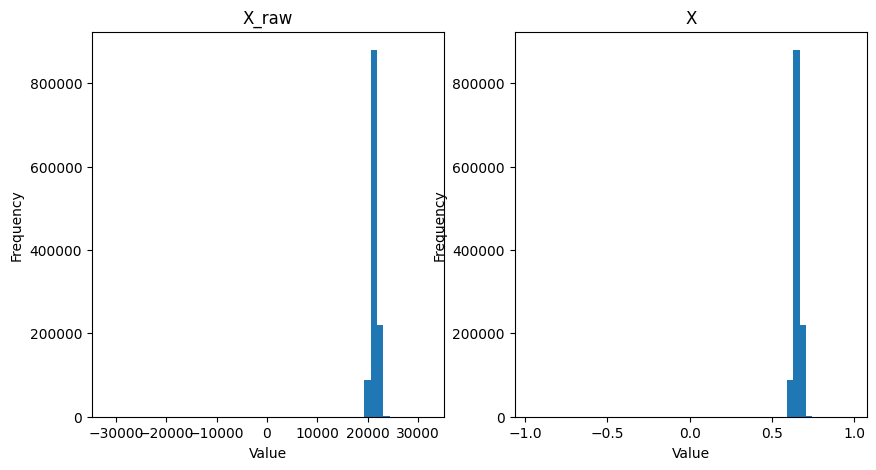

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(x_raw.view(-1).numpy(), 50) 
axs[0].set_title("X_raw")
axs[0].set_xlabel('Value')
axs[0].set_ylabel('Frequency')

axs[1].hist(x.view(-1).numpy(), 50)
axs[1].set_title("X")
axs[1].set_xlabel('Value')
axs[1].set_ylabel('Frequency')


plt.show()

idx += 1
x_raw, x, y = k1d_ds[idx]

## Define model

In [ ]:
class SegmentationModel(nn.Module):
    def __init__(self, in_channels, num_classes):
        super(SegmentationModel, self).__init__()

        # Define the encoder - a series of convolutional layers
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Define the decoder - a series of transposed convolutional layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, num_classes, kernel_size=3, padding=1)
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Initialize the model with the desired input channels and number of classes
model = SegmentationModel(in_channels=1, num_classes=1)

# Use the model for a batch of input images
input_batch = torch.rand(1, 1, 256, 256)
output = model(input_batch)

## Define evaluation metric

In [ ]:
class IouMetric:
    def __init__(self, num_classes: int, int2str: dict, ignore_index: int = 255, prefix="train"):
        """
        Args:
            num_classes: number of classes
            int2str: dictionary mapping class index to class name
            ignore_index: index to ignore in the metric calculations
            prefix: prefix to use for logging
        """
        self.area_intersect = torch.zeros(num_classes)
        self.area_label = torch.zeros(num_classes)
        self.area_pred = torch.zeros(num_classes)
        self.num_classes = num_classes
        self.int2str = int2str
        self.ignore_index = ignore_index
        self.prefix = prefix

    def process(self, preds, labels):
        mask = labels != self.ignore_index
        preds = preds[mask]
        labels = labels[mask]

        # compute area of intersection, label and prediction
        intersect = preds[preds == labels]
        area_intersect = torch.histc(intersect.float(), bins=self.num_classes, min=0, max=self.num_classes - 1)
        area_label = torch.histc(labels.float(), bins=self.num_classes, min=0, max=self.num_classes - 1)
        area_pred = torch.histc(preds.float(), bins=self.num_classes, min=0, max=self.num_classes - 1)

        # update results
        self.area_intersect += area_intersect.cpu()
        self.area_label += area_label.cpu()
        self.area_pred += area_pred.cpu()

    def compute(self) -> dict:
        iou = self.area_intersect / (self.area_label + self.area_pred - self.area_intersect)
        if 0 <= self.ignore_index <= self.num_classes - 1:
            iou[self.ignore_index] = torch.nan
        mean_iou = torch.nanmean(iou)

        metrics = {
            f"{self.prefix}/iou_{self.int2str[idx]}": iou[idx].item()
            for idx in range(len(iou))
            if idx != self.ignore_index
        }
        metrics[f"{self.prefix}/mean_iou"] = mean_iou.item()

        return metrics

    def reset(self):
        self.area_intersect.zero_()
        self.area_label.zero_()
        self.area_pred.zero_()


## Define loss function


In [ ]:
loss_fn = nn.BCEWithLogitsLoss()

## Train model

### Optimizer and scheduler

### Train method

### Evaluation method

## Make submisssion